# 2. Model Train

## Model ResNet50

### Import libraries

In [59]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

In [60]:
np.random.seed(12049)

In [61]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()


def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

### Load data

In [62]:
base_dir = "../dataset/"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

### Definitions

In [63]:
model_name = "ResNet50"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join('models', f'model_{model_name}_ft.hdf5')

### Image data generator

In [64]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [65]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [66]:
y_train = train_generator.labels
y_val = valid_generator.labels

### Weight data

In [67]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


### Train data

In [68]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01, 
                min_lr=1e-10, patience=4, mode='auto'
            )

In [69]:
model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

### Fine-tuning

In [70]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [71]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100


2022-12-29 08:19:41.967730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - ETA: 0s - loss: 1.9019 - accuracy: 0.1873

2022-12-29 08:21:12.623971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/181 [==============================] - 100s 517ms/step - loss: 1.9019 - accuracy: 0.1873 - val_loss: 4.3554 - val_accuracy: 0.0908 - lr: 0.0010
Epoch 2/100
181/181 [==============================] - 88s 485ms/step - loss: 1.7002 - accuracy: 0.1362 - val_loss: 1.6100 - val_accuracy: 0.1804 - lr: 0.0010
Epoch 3/100
181/181 [==============================] - 88s 483ms/step - loss: 1.6472 - accuracy: 0.1751 - val_loss: 1.5753 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 4/100
181/181 [==============================] - 87s 480ms/step - loss: 1.6387 - accuracy: 0.1878 - val_loss: 1.6214 - val_accuracy: 0.2433 - lr: 0.0010
Epoch 5/100
181/181 [==============================] - 87s 482ms/step - loss: 1.6328 - accuracy: 0.1907 - val_loss: 1.6238 - val_accuracy: 0.2179 - lr: 0.0010
Epoch 6/100
181/181 [==============================] - 87s 482ms/step - loss: 1.6259 - accuracy: 0.1899 - val_loss: 1.6083 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 7/100
181/181 [==============================] - 87

In [72]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model {model_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ResNet50 fine tuning executed in 80.25 minutes


In [73]:
model_ft.save(save_model_ft)

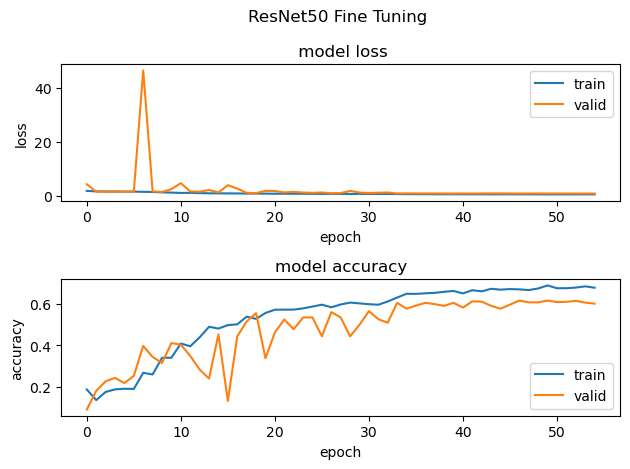

In [74]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [75]:
get_evaluate(valid_generator, "Valid", model_ft)

26/26 [==============================] - 4s 142ms/step - loss: 0.8990 - accuracy: 0.6150
Valid loss: 0.90
Valid accuracy: 0.62


In [76]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

2022-12-29 09:39:58.529091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 6s 177ms/step
Accuracy Score - ResNet50: 0.62
Balanced Accuracy Score - ResNet50: 0.65


              precision    recall  f1-score   support

           0       0.74      0.74      0.74       328
           1       0.32      0.42      0.36       153
           2       0.66      0.49      0.56       212
           3       0.68      0.69      0.68       106
           4       0.80      0.89      0.84        27

    accuracy                           0.62       826
   macro avg       0.64      0.65      0.64       826
weighted avg       0.64      0.62      0.62       826



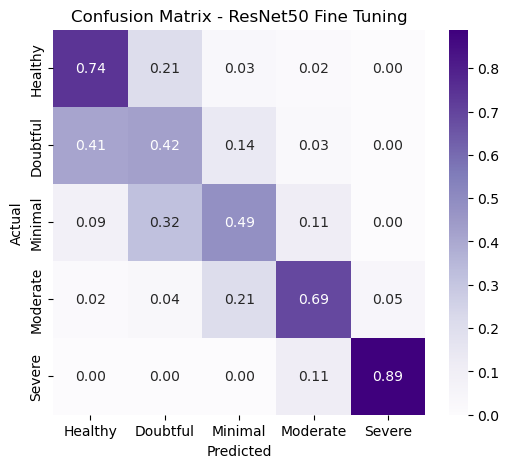

In [77]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)